# AIOE 데이터 분석 및 시각화 (EDA)

이 노트북에서는 02번에서 계산된 AIOE 점수를 다양한 관점에서 **탐색**하고 **시각화**합니다.

## EDA(Exploratory Data Analysis)란?

**탐색적 데이터 분석** - 데이터를 여러 각도에서 살펴보고 패턴을 발견하는 과정

**이 노트북의 목표:**
- 📊 AIOE 점수가 어떻게 분포되어 있나?
- 🏆 어떤 직업이 AI에 가장 많이/적게 노출되나?
- 🏢 어떤 직업군이 AI 영향을 많이 받나?

## 사용할 분석 기법

1. **기술 통계** - 평균, 표준편차, 최소/최대값
2. **시각화** - 히스토그램, 박스플롯, 바차트
3. **그룹 비교** - 직업군별 AIOE 비교

In [1056]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# 데이터 경로 설정
PROCESSED_DIR = '../datas/processed'

---

## 1. 데이터 로드 및 확인

### 사용할 데이터

02번 노트북에서 계산한 **직업별 AIOE 점수 데이터**를 사용합니다:

**aioe_master.csv**
- **894개 행** (894개 직업)
- **8개 컬럼**:
  - `soc_code`: 직업 코드
  - `title`: 직업명
  - `total_weight_impact`: AI 영향도 총합
  - `ability_base`: 능력 가중치 총합
  - `n_abil`: 능력 개수 (52개)
  - `abil_base_impact`: AIOE 기본 점수 (0~1)
  - `aioe`: AIOE 표준화 점수 (Z-score)
  - `rank`: AIOE 순위 (1~894)

In [1057]:
# 데이터 로드
df = pd.read_csv(f'{PROCESSED_DIR}/aioe_master.csv')

# Title 컬럼명을 title로 수정
df = df.rename(columns={'Title': 'title'})

# rank 순으로 정렬 (1위부터)
df = df.sort_values('rank').reset_index(drop=True)

# 컬럼 순서 재배치 (rank, soc_code, title, aioe를 앞으로)
df = df[['rank', 'soc_code', 'title', 'aioe', 'abil_base_impact', 
         'total_weight_impact', 'ability_base', 'n_abil']]

df.head()

,rank,soc_code,title,aioe,abil_base_impact,total_weight_impact,ability_base,n_abil
0,1,25-1123.00,"English Language and Literature Teachers, Post...",1.790905,0.744991,6.093471,8.179251,52
1,2,25-1124.00,"Foreign Language and Literature Teachers, Post...",1.747358,0.741313,5.797188,7.820160,52
2,3,25-1125.00,"History Teachers, Postsecondary",1.746821,0.741268,5.726811,7.725697,52
3,4,25-1112.00,"Law Teachers, Postsecondary",1.735193,0.740286,6.276686,8.478734,52
4,5,25-1126.00,"Philosophy and Religion Teachers, Postsecondary",1.733154,0.740114,5.703488,7.706234,52


In [1058]:
# 데이터 기본 정보
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 894 entries, 0 to 893
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   rank                 894 non-null    int64  
 1   soc_code             894 non-null    object 
 2   title                894 non-null    object 
 3   aioe                 894 non-null    float64
 4   abil_base_impact     894 non-null    float64
 5   total_weight_impact  894 non-null    float64
 6   ability_base         894 non-null    float64
 7   n_abil               894 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 56.0+ KB


In [1059]:
# 기술 통계
df.describe()

,rank,aioe,abil_base_impact,total_weight_impact,ability_base,n_abil
count,894.000000,8.940000e+02,894.000000,894.000000,894.000000,894.0
mean,447.500000,-3.814995e-16,0.593728,5.801786,9.878790,52.0
std,258.219868,1.000560e+00,0.084509,1.074563,1.887109,0.0
min,1.000000,-1.969738e+00,0.427360,2.540281,4.712111,52.0
25%,224.250000,-9.430924e-01,0.514072,5.069913,8.570105,52.0
50%,447.500000,2.032535e-02,0.595445,5.781726,9.779817,52.0
75%,670.750000,9.538739e-01,0.674294,6.527871,11.115496,52.0
max,894.000000,1.790905e+00,0.744991,10.008248,19.224449,52.0


### 📊 기술 통계 해석

**과학적 표기법:**
- `-3.8e-16` = -3.8 × 10⁻¹⁶ = -0.00000000000000038
- 사실상 **0** (컴퓨터 계산의 부동소수점 오차)

**aioe 컬럼 주요 지표:**
- **mean = 0**: Z-score의 특성 (표준화된 점수)
- **std = 1.00**: Z-score의 특성 (표준편차 = 1)
- **50% (중앙값) = 0.02**: 절반은 양수, 절반은 음수
- **min = -1.97, max = 1.79**: 모든 직업이 ±2 범위 내 (정상 범위)

---

## 2. AIOE 점수 분포 분석

### 2.1 전체 분포 확인

894개 직업의 AIOE 점수가 어떻게 분포되어 있는지 살펴봅니다.

**Z-score 특성:**
- 평균 = 0
- 표준편차 = 1
- 대부분 -2 ~ +2 사이에 분포
- 양수 = 평균보다 높음 (AI 노출도 높음)
- 음수 = 평균보다 낮음 (AI 노출도 낮음)

In [1060]:
# AIOE 기본 통계
df['aioe'].describe()

count    8.940000e+02
mean    -3.814995e-16
std      1.000560e+00
min     -1.969738e+00
25%     -9.430924e-01
50%      2.032535e-02
75%      9.538739e-01
max      1.790905e+00
Name: aioe, dtype: float64

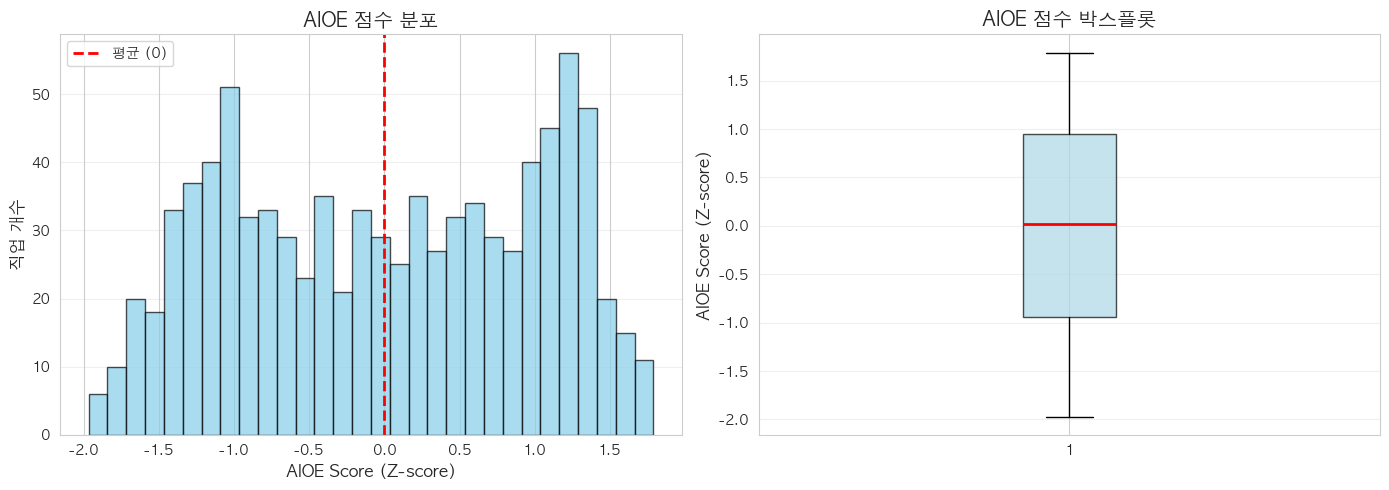

In [1061]:
# AIOE 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 히스토그램
axes[0].hist(df['aioe'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].set_xlabel('AIOE Score (Z-score)', fontsize=12)
axes[0].set_ylabel('직업 개수', fontsize=12)
axes[0].set_title('AIOE 점수 분포', fontsize=14, fontweight='bold')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='평균 (0)')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# 박스플롯
axes[1].boxplot(df['aioe'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('AIOE Score (Z-score)', fontsize=12)
axes[1].set_title('AIOE 점수 박스플롯', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 📊 차트 해석

**히스토그램**
- **이봉분포(Bimodal Distribution)** 형태
- 두 개의 봉우리가 관찰됨:
  - 음수 구간 (-0.8 ~ -1.0 근처): AI 노출도 낮은 직업군
  - 양수 구간 (+0.8 ~ +1.2 근처): AI 노출도 높은 직업군
- 중간 구간(0 근처)의 직업이 상대적으로 적음

**박스플롯**
- 중앙값(빨간 선) ≈ 0.02 (평균과 거의 일치)
- 상자가 대칭적 → 균형 잡힌 분포
- 이상치(점) 없음 → 모든 직업이 정상 범위 내

**의미:**
- AI 노출도가 **양극화** 경향: "낮은 그룹"과 "높은 그룹"으로 분리
- **화이트칼라 vs 블루칼라** 구조적 차이를 반영
- 중간 지대 직업(AI 영향이 애매한 직업)이 상대적으로 적음

### 2.2 AI 노출도 TOP 10 & BOTTOM 10

**rank 컬럼의 의미:**
- rank = 1: AIOE가 가장 높은 직업 (AI 노출도 최고)
- rank = 894: AIOE가 가장 낮은 직업 (AI 노출도 최저)

In [1062]:
# TOP 10 직업 (rank가 작을수록 AIOE 높음)
top_10 = df.nsmallest(10, 'rank')
top_10[['rank', 'title', 'aioe']]

,rank,title,aioe
0,1,"English Language and Literature Teachers, Post...",1.790905
1,2,"Foreign Language and Literature Teachers, Post...",1.747358
2,3,"History Teachers, Postsecondary",1.746821
3,4,"Law Teachers, Postsecondary",1.735193
4,5,"Philosophy and Religion Teachers, Postsecondary",1.733154
5,6,Telemarketers,1.717130
6,7,"Sociology Teachers, Postsecondary",1.703340
7,8,"Political Science Teachers, Postsecondary",1.702435
8,9,"Criminal Justice and Law Enforcement Teachers,...",1.686785
9,10,"Social Work Teachers, Postsecondary",1.681822


In [1063]:
# BOTTOM 10 직업 (rank가 클수록 AIOE 낮음)
bottom_10 = df.nlargest(10, 'rank').sort_values('rank')  # 오름차순 정렬
bottom_10[['rank', 'title', 'aioe']]

,rank,title,aioe
893,894,"Pressers, Textile, Garment, and Related Materials",-1.969738
892,893,"Helpers--Brickmasons, Blockmasons, Stonemasons...",-1.937150
891,892,Dancers,-1.908095
890,891,Fallers,-1.906417
889,890,Reinforcing Iron and Rebar Workers,-1.896098
888,889,"Farmworkers and Laborers, Crop, Nursery, and G...",-1.885781
887,888,"Helpers--Painters, Paperhangers, Plasterers, a...",-1.825034
886,887,Structural Iron and Steel Workers,-1.814734
885,886,Terrazzo Workers and Finishers,-1.798524
884,885,Cement Masons and Concrete Finishers,-1.791071


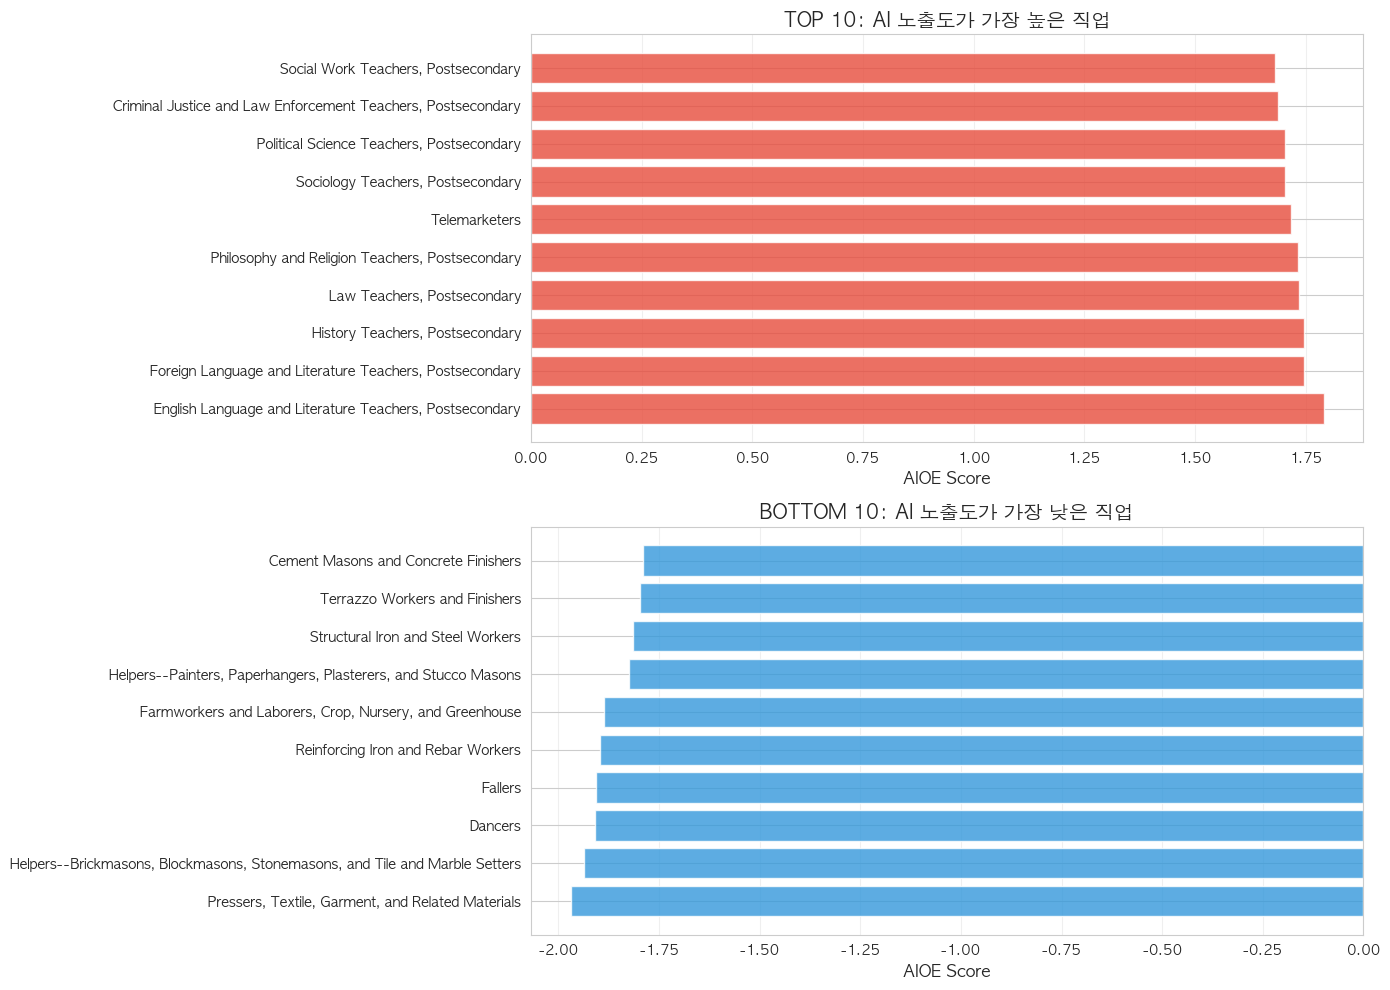

In [1064]:
# TOP 10 vs BOTTOM 10 시각화
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# TOP 10 (AIOE 높은 순으로 표시)
axes[0].barh(top_10['title'], top_10['aioe'], color='#e74c3c', alpha=0.8)
axes[0].set_xlabel('AIOE Score', fontsize=12)
axes[0].set_title('TOP 10: AI 노출도가 가장 높은 직업', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# BOTTOM 10 (AIOE 낮은 순으로 표시 = rank 큰 순)
# iloc[::-1]로 역순 정렬하여 894위(가장 낮은)가 맨 위에 오도록
axes[1].barh(bottom_10['title'].iloc[::-1], bottom_10['aioe'].iloc[::-1], color='#3498db', alpha=0.8)
axes[1].set_xlabel('AIOE Score', fontsize=12)
axes[1].set_title('BOTTOM 10: AI 노출도가 가장 낮은 직업', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

---

## 3. 직업군별 AIOE 비교

### 3.1 SOC 대분류 (22개 직업군)

O*NET의 **SOC(Standard Occupational Classification)** 코드 체계를 사용하여 894개 직업을 22개 대분류로 그룹화합니다.

**SOC 코드 형식:**
- `11-1011.00` → **11**(대분류) - 1011(세부직업) . 00(전문화)
- 앞 2자리가 직업군을 나타냄

**분석 목표:**
- 어떤 직업군이 AI에 가장 많이 노출되나?
- 직업군 간 차이는 얼마나 크나?

In [1065]:
# SOC 대분류 이름 매핑
soc_major_names = {
    '11': '경영', '13': '사무/금융', '15': '컴퓨터/수학', '17': '건축/공학',
    '19': '과학', '21': '지역사회/사회', '23': '법률', '25': '교육',
    '27': '예술/디자인/미디어', '29': '보건', '31': '보건지원', '33': '보안',
    '35': '음식서비스', '37': '건물관리', '39': '개인서비스', '41': '판매',
    '43': '사무지원', '45': '농림어업', '47': '건설', '49': '설치/정비',
    '51': '생산', '53': '운송'
}

# SOC 대분류 추출
df['soc_major'] = df['soc_code'].str[:2]
df['soc_major_name'] = df['soc_major'].map(soc_major_names)

# 매핑 검증
unmapped = df[df['soc_major_name'].isna()]
if len(unmapped) > 0:
    print(f"⚠️ 매핑되지 않은 SOC 코드: {unmapped['soc_major'].unique()}")
else:
    print(f"✅ 모든 SOC 코드 매핑 완료 ({df['soc_major'].nunique()}개 직업군)")

✅ 모든 SOC 코드 매핑 완료 (22개 직업군)


In [1066]:
# 직업군별 통계
major_stats = df.groupby('soc_major_name')['aioe'].agg(['count', 'mean', 'std']).sort_values('mean', ascending=False)
major_stats

,count,mean,std
soc_major_name,,,
법률,7,1.464912,0.173788
교육,61,1.129660,0.517249
지역사회/사회,14,1.096102,0.453048
사무/금융,45,1.027204,0.447589
컴퓨터/수학,31,0.953624,0.272465
경영,54,0.823124,0.485332
판매,21,0.691543,0.672798
과학,59,0.662843,0.620670
사무지원,51,0.571412,0.744986


**표준편차(std)의 의미:**
- **작음 (법률 0.17)**: 직업군 내 직업들이 비슷한 AIOE
  - 예: 변호사, 판사 모두 AIOE 높음 (균일)
- **큼 (예술/디자인 0.83)**: 직업군 내 편차 큼
  - 예: 작가(AIOE 높음) vs 무용수(AIOE 낮음)

**샘플 수(count):**
- 법률 7개 vs 생산 107개
- 샘플이 많을수록 평균의 **신뢰성** 높음
- 법률 직군은 샘플이 적어 해석 시 주의 필요

### 3.2 직업군별 평균 AIOE 비교

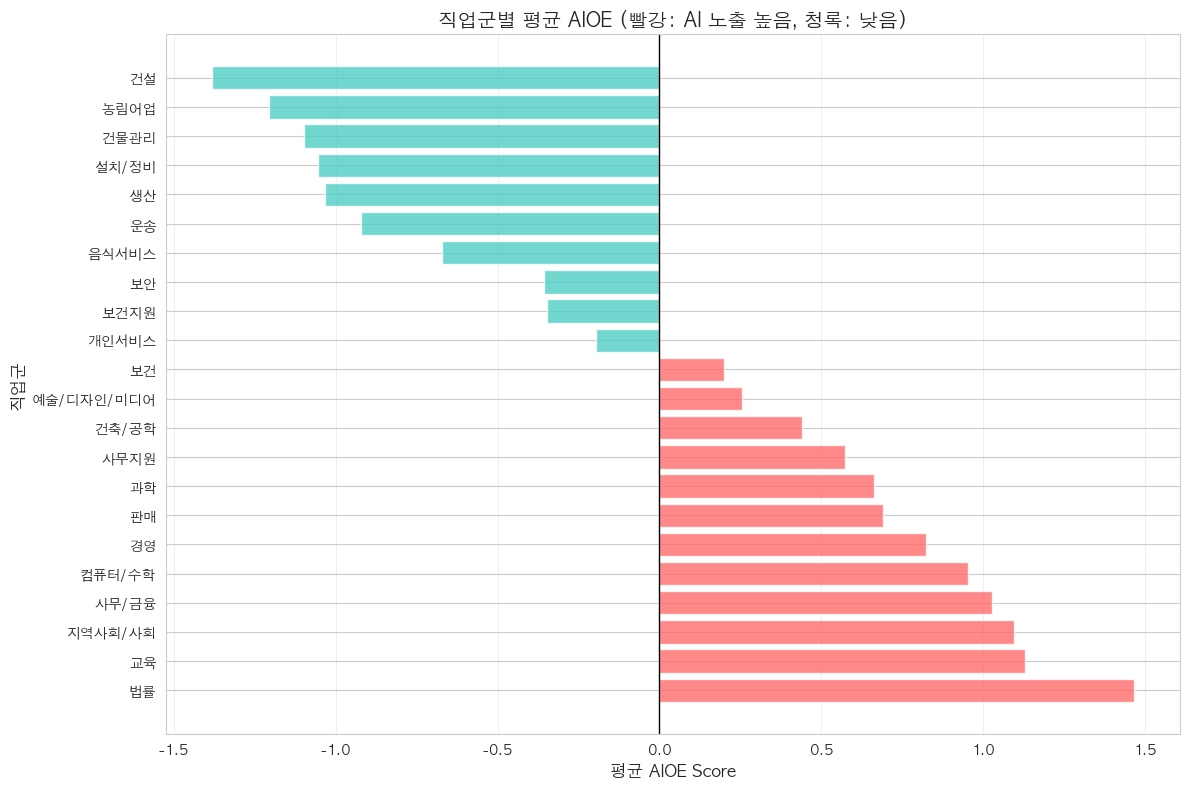

In [1067]:
# 직업군별 평균 AIOE 시각화
plt.figure(figsize=(12, 8))

# 색상 지정: 양수는 빨강, 음수는 청록색
colors = ['#FF6B6B' if x > 0 else '#4ECDC4' for x in major_stats['mean']]

# 막대 그래프
plt.barh(major_stats.index, major_stats['mean'], color=colors, alpha=0.8)

# 기준선 (0)
plt.axvline(0, color='black', linestyle='-', linewidth=1)

# 레이블 및 제목
plt.xlabel('평균 AIOE Score', fontsize=12)
plt.ylabel('직업군', fontsize=12)
plt.title('직업군별 평균 AIOE (빨강: AI 노출 높음, 청록: 낮음)', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

---

## 4. 결론

### 핵심 발견

1. **AIOE 분포**
   - 이봉분포(Bimodal) 형태: 양극화 현상
   - AI 노출도가 높은 직업과 낮은 직업이 명확히 구분됨

2. **AI 노출도가 높은 직업**
   - 교육 관련 직업 (교수, 교사)
   - 사무/금융 관련 직업
   - 법률 관련 직업
   - **공통점**: 언어/정보 처리가 핵심인 직업

3. **AI 노출도가 낮은 직업**
   - 건설 관련 직업
   - 생산/제조 관련 직업
   - 농림어업 관련 직업
   - **공통점**: 신체적/물리적 작업이 핵심인 직업

4. **직업군별 차이**
   - 법률, 교육, 사무/금융 직군이 높은 AIOE (평균 > 1.0)
   - 건설, 생산, 운송 직군이 낮은 AIOE (평균 < -0.9)
   - 같은 직업군 내에서도 편차가 존재 (표준편차 참고)

### 인사이트

- **언어 모델 AI는 화이트칼라 직업에 더 큰 영향**을 미칩니다
- 단순히 "고학력 직업"이 아니라 "언어/사고 능력 중심 직업"이 영향을 많이 받습니다
- 신체적/물리적 작업은 현재 언어 모델 AI로는 대체하기 어렵습니다
- 직업 시장의 **양극화 구조**가 AIOE 분포에 명확히 반영됨